GAN(Generative Adversarial Network)**을 구현하는 간단한 예제 코드입니다.

이 예제는 MNIST 데이터셋(손글씨 숫자 이미지)을 사용하여 GAN을 학습하고 새로운 숫자 이미지를 생성하는 과정

# GAN

## 라이브러리

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

## 하이퍼파라미터 설정

In [2]:
# latent_dim = 100: 생성기에 입력될 **잠재 공간(latent space)**의 크기를 100으로 설정합니다.
# 이 잠재 공간에서 랜덤 벡터를 샘플링하여 새로운 이미지를 생성합니다.

In [3]:
# 하이퍼파라미터 설정
latent_dim = 100  # 생성기(Generator)에 입력될 잠재 공간의 크기

## 모델 정의

### 생성기 모델 정의

In [4]:
# build_generator(): 생성기는 랜덤한 잠재 벡터(노이즈)에서 28x28 픽셀 크기의 이미지를 생성하는 모델입니다.
# 여러 Dense 층과 LeakyReLU 활성화 함수를 사용하여 잠재 공간의 벡터를 고차원으로 변환합니다.
# 마지막 출력층에서 tanh 활성화 함수를 사용하여 이미지의 픽셀 값을 -1에서 1로 출력합니다.

In [5]:

def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

### 판별기 모델 정의

In [6]:
# build_discriminator(): 판별기는 입력받은 이미지가 **진짜(1)**인지 **가짜(0)**인지 판별하는 모델입니다.
# Flatten 층으로 이미지를 1차원 벡터로 변환하고, 여러 Dense 층을 통해 진짜/가짜를 분류합니다.
# 마지막 출력층에서 sigmoid 활성화 함수를 사용하여 이진 분류를 수행합니다.

In [7]:

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

### GAN 모델 정의

In [8]:
# build_gan(): GAN은 생성기와 판별기를 결합한 모델입니다.
#     생성기는 랜덤 노이즈를 입력받아 이미지를 생성하고, 판별기는 이 이미지를 입력받아 진짜인지 가짜인지를 판별합니다.
# 이때, 판별기는 고정하고, 생성기가 판별기를 속이도록 학습합니다.

In [9]:
# GAN 모델 정의
def build_gan(generator, discriminator):
    discriminator.trainable = False  # GAN 학습에서 판별기는 고정
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [10]:
# 모델 학습 함수 정의
def train(epochs, batch_size=128, save_interval=200):
    # MNIST 데이터셋 로드 및 전처리
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0  # 0~255 범위의 값을 -1 ~ 1로 정규화
    X_train = np.expand_dims(X_train, axis=3)  # 차원 추가 (28x28x1)

    # 실제 이미지의 레이블은 1, 가짜 이미지의 레이블은 0
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  판별기 학습
        # ---------------------
        # 실제 이미지로부터 랜덤 배치 추출
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # 랜덤 잠재 벡터 생성
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # 생성기로부터 가짜 이미지 생성
        gen_imgs = generator.predict(noise)

        # 판별기 학습 (진짜 이미지 -> 1, 가짜 이미지 -> 0)
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성기 학습
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # 생성기가 판별기를 속이도록 학습 (가짜 이미지 -> 1로 판별되도록)
        g_loss = gan.train_on_batch(noise, valid)

        # 일정 간격으로 진행 상황 출력
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

# 생성기, 판별기, GAN 모델 생성
optimizer = Adam(0.0002, 0.5)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


c:\users\jyb\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\users\jyb\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\users\jyb\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 모델 학습

In [11]:
# train() 함수에서 생성기와 판별기를 학습시킵니다.
# 학습 중에 진짜 이미지와 가짜 이미지를 판별기에게 학습시켜서, 판별기가 진짜와 가짜를 구분하도록 합니다.
# 동시에, 생성기는 판별기를 속이기 위해 가짜 이미지를 더욱 진짜처럼 만들도록 학습합니다.
# 일정 간격마다 손실 값(D loss, G loss)을 출력하여 학습 진행 상황을 확인합니다.

In [12]:
# 모델 학습
train(epochs=10000, batch_size=64, save_interval=1000)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 


AttributeError: 'NoneType' object has no attribute 'update_state'

In [ ]:
# 결과 출력
# 학습이 진행되면 다음과 같은 정보가 출력됩니다:

# D loss: 판별기의 손실 값
# G loss: 생성기의 손실 값

## 코드 종합

In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

# 하이퍼파라미터 설정
latent_dim = 100  # 생성기(Generator)에 입력될 잠재 공간의 크기

# 생성기 모델 정의
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# 판별기 모델 정의
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN 모델 정의
def build_gan(generator, discriminator):
    discriminator.trainable = False  # GAN 학습에서 판별기는 고정
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# 모델 학습 함수 정의
def train(epochs, batch_size=128, save_interval=200):
    # MNIST 데이터셋 로드 및 전처리
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0  # 0~255 범위의 값을 -1 ~ 1로 정규화
    X_train = np.expand_dims(X_train, axis=3)  # 차원 추가 (28x28x1)

    # 실제 이미지의 레이블은 1, 가짜 이미지의 레이블은 0
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  판별기 학습
        # ---------------------
        # 실제 이미지로부터 랜덤 배치 추출
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # 랜덤 잠재 벡터 생성
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # 생성기로부터 가짜 이미지 생성
        gen_imgs = generator.predict(noise)

        # 판별기 학습 (진짜 이미지 -> 1, 가짜 이미지 -> 0)
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성기 학습
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # 생성기가 판별기를 속이도록 학습 (가짜 이미지 -> 1로 판별되도록)
        g_loss = gan.train_on_batch(noise, valid)

        # 일정 간격으로 진행 상황 출력
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

# 생성기, 판별기, GAN 모델 생성
optimizer = Adam(0.0002, 0.5)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

# 모델 학습
train(epochs=10000, batch_size=64, save_interval=1000)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 1.0507118701934814] [G loss: [array(0.8783446, dtype=float32), array(0.8783446, dtype=float32), array(0.5, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

# Conditional GAN (cGAN) 모델

In [ ]:
#  Python과 TensorFlow로 구현하여 특정 조건에 따라 이미지를 생성하는 예제를 보여드리겠습니다.
# 여기서는 MNIST 데이터셋을 이용해, 각 숫자(0-9)를 조건으로 사용하여 해당 숫자에 해당하는 이미지를 생성하는 간단한 cGAN 모델을 구축해 보겠습니다.

## 기본 라이브러리 가져오기 및 데이터 로드

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Embedding, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터 로드
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # -1과 1 사이로 정규화
x_train = np.expand_dims(x_train, axis=3)  # 채널 차원 추가 (28, 28, 1)
y_train = y_train.reshape(-1, 1)  # 라벨을 (N, 1) 형식으로 변환


## cGAN 생성자 모델 정의

In [ ]:
# 생성자는 노이즈 벡터와 조건을 입력받아 조건에 맞는 이미지를 생성합니다.

In [ ]:
# 코드 설명
# 생성자: 조건(레이블)과 노이즈를 입력받아 해당 조건에 맞는 이미지를 생성합니다.
# 판별자: 이미지와 조건을 입력받아 진짜와 가짜를 판별합니다.
# 학습: 생성자와 판별자가 서로 경쟁하면서 학습됩니다. 일정 주기마다 생성된 숫자 이미지를 확인할 수 있습니다.
# 이 코드를 실행하면 조건부로 숫자 이미지를 생성하는 cGAN 모델을 학습할 수 있습니다.

In [ ]:
def build_generator():
    noise = Input(shape=(100,))
    label = Input(shape=(1,), dtype='int32')

    # 라벨을 Embedding하여 노이즈에 추가
    label_embedding = Flatten()(Embedding(10, 100)(label))
    model_input = multiply([noise, label_embedding])

    # 생성자 네트워크
    x = Dense(128 * 7 * 7, activation="relu")(model_input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same", activation='tanh')(x)

    model = Model([noise, label], x)
    return model


##  cGAN 판별자 모델 정의

In [ ]:
# 판별자는 이미지와 조건을 입력받아 이미지가 진짜인지 가짜인지 판별합니다.

In [ ]:
def build_discriminator():
    img = Input(shape=(28, 28, 1))
    label = Input(shape=(1,), dtype='int32')

    # 라벨을 Embedding하여 이미지에 추가
    label_embedding = Flatten()(Embedding(10, 28 * 28)(label))
    label_embedding = Reshape((28, 28, 1))(label_embedding)

    model_input = multiply([img, label_embedding])

    # 판별자 네트워크
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model([img, label], x)
    return model


## cGAN 모델 컴파일 및 학습 설정

In [ ]:
# GAN의 판별자와 생성자를 컴파일하고, 생성자와 판별자를 결합한 전체 cGAN 모델을 정의합니다.

In [ ]:
# 생성자와 판별자 모델 생성
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# cGAN 모델
noise = Input(shape=(100,))
label = Input(shape=(1,))
generated_img = generator([noise, label])
discriminator.trainable = False  # cGAN 훈련 시 판별자 가중치 고정
validity = discriminator([generated_img, label])

cgan = Model([noise, label], validity)
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


## cGAN 학습 함수

In [ ]:
# GAN 모델을 학습하는 함수로, 생성자와 판별자가 서로 경쟁하면서 성능을 개선해 나갑니다.

In [ ]:
def train(epochs, batch_size=128):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # ---------------------
        # 판별자 훈련
        # ---------------------

        # 진짜 이미지 샘플링
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs, labels = x_train[idx], y_train[idx]

        # 가짜 이미지 생성
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_labels = np.random.randint(0, 10, (half_batch, 1))
        gen_imgs = generator.predict([noise, gen_labels])

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch([imgs, labels], np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        # 생성자 훈련
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))

        # 생성자를 통한 가짜 이미지로 판별자 속이기
        valid = np.ones((batch_size, 1))
        g_loss = cgan.train_on_batch([noise, sampled_labels], valid)

        # 진행 상황 출력
        if epoch % 100 == 0:
            print(f"{epoch} [D 손실: {d_loss[0]}, 정확도: {100 * d_loss[1]}] [G 손실: {g_loss}]")
            sample_images(epoch)

# 이미지 생성 함수
def sample_images(epoch, rows=2, cols=5):
    noise = np.random.normal(0, 1, (rows * cols, 100))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([noise, labels])

    # 이미지 스케일링 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, cols, figsize=(10, 4))
    for i in range(rows * cols):
        axs[i // cols, i % cols].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[i // cols, i % cols].set_title(f"Digit: {labels[i]}")
        axs[i // cols, i % cols].axis('off')
    plt.show()


## 모델 학습 시작

In [ ]:
# cGAN 모델 학습
train(epochs=10000, batch_size=64)


## 결과 해석

In [ ]:
# cGAN 모델의 결과 해석:

# 학습 진행 상황 출력:
# 매 100 에포크마다 출력되는 메시지는 현재 모델의 학습 상태를 보여줍니다.
# 출력 예시: 100 [D 손실: 0.675, 정확도: 75.0] [G 손실: 0.789]
# [D 손실: X]: 판별자의 손실 값입니다. 손실이 낮을수록 판별자가 진짜와 가짜 이미지를 잘 구분하고 있음을 의미합니다.
# 정확도: 판별자가 진짜와 가짜 이미지를 얼마나 잘 구분하는지를 보여줍니다.
# 정확도가 너무 높아지면 판별자가 생성자를 쉽게 구별한다는 의미이므로, 일정 수준의 균형이 필요합니다.
# [G 손실: Y]: 생성자의 손실 값입니다. 생성자가 판별자를 잘 속여, 가짜 이미지를 진짜로 인식하게 만들 수 있는지의 여부를 나타냅니다. 생성자 손실이 낮아지면 생성된 이미지의 품질이 높아진다고 볼 수 있습니다.

# # 이미지 생성 결과 (조건부 이미지 샘플):
# sample_images 함수를 통해 각 숫자 레이블(0-9)에 대해 생성된 이미지를 볼 수 있습니다.
# 생성된 이미지가 조건에 맞는 숫자 이미지를 잘 표현할수록, 생성자가 원하는 조건에 맞게 이미지를 생성하고 있음을 의미합니다.

# 결과 해석 기준:
# 균형 유지: 판별자와 생성자 손실이 적절하게 균형을 이루는 것이 중요합니다.
# # 판별자의 정확도가 50~80% 사이에 유지되면서 손실이 안정적이라면 학습이 잘 진행되고 있다고 볼 수 있습니다.
# 생성 이미지 품질: 학습이 잘 진행될수록 sample_images에서 생성된 숫자 이미지가 해당 숫자 클래스에 맞게 뚜렷하게 나타납니다.
# # 초기 에포크에는 이미지가 흐리거나 왜곡될 수 있으나, 에포크가 증가하면 이미지가 점차 선명해지고 조건에 맞게 생성됩니다.

# 최종 목표
# 학습이 완료되면 생성자는 각 숫자 레이블(0-9)에 맞는 숫자 이미지를 판별자가 진짜로 인식할 정도의 품질로 생성할 수 있게 됩니다. 이를 통해 cGAN 모델이 조건부 이미지 생성을 성공적으로 학습했음을 확인할 수 있습니다.

# 삼성전자 이상치를 탐지하는 방법

In [ ]:
# 데이터 전처리: 이상치가 포함된 샘플 금융 데이터를 생성합니다. 이 데이터를 스케일링하여 GAN에 사용할 준비를 합니다.
# GAN 모델 정의: 생성자와 판별자 모델을 정의합니다. 생성자는 정상 패턴을 학습하고, 판별자는 실제와 가짜 데이터를 구별하도록 학습됩니다.
# 모델 학습: GAN을 반복 학습하여 생성자가 정상 패턴을 생성할 수 있도록 만듭니다.
# 이상치 탐지: 각 데이터 포인트를 생성자가 생성한 데이터와 비교하여 판별 점수를 기반으로 이상치 점수를 계산합니다. 판별 점수가 기준 이상일 경우 이상치로 간주합니다.
# 결과 시각화: 이상치로 판별된 데이터 포인트를 빨간색으로 표시하여 데이터와 함께 시각화합니다.

In [ ]:
# 삼성전자의 일별 주가 데이터를 기반으로 GAN을 학습하여 이상치를 탐지하고 시각화합니다. 이상치 탐지의 정확도는 모델의 학습 상태와 데이터의 특성에 따라 달라질 수 있으므로, 하이퍼파라미터 조정과 추가적인 데이터 전처리가 필요할 수 있습니다.

## 라이브러리 설치 및 임포트

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
import matplotlib.pyplot as plt


## 삼성전자 주가 데이터 가져오기

In [4]:
# 삼성전자 티커
ticker = '005930.KS'

# 데이터 다운로드
df = yf.download(ticker, start='2020-01-01', end='2024-11-06')

# 종가(Close) 데이터만 사용
data = df['Close'].values.reshape(-1, 1)


[*********************100%***********************]  1 of 1 completed


In [ ]:
print(data)

[[55200.]
 [55500.]
 [55500.]
 ...
 [58300.]
 [58700.]
 [57600.]]


## 데이터 전처리

In [5]:
# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)


## GAN 모델 정의

In [ ]:
# 생성자(Generator)와 판별자(Discriminator) 모델을 정의

In [6]:
def build_generator(latent_dim):
    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(1, activation='tanh')
    ])
    return model

def build_discriminator():
    model = Sequential([
        Dense(512, input_shape=(1,)),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    return model


## GAN 모델 컴파일

In [ ]:
# 생성자와 판별자를 컴파일하고, GAN 모델을 구성합니다.

In [7]:
latent_dim = 10
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## GAN 모델 학습

In [8]:
def train_gan(epochs, batch_size=32):
    for epoch in range(epochs):
        # 진짜 데이터 샘플링
        idx = np.random.randint(0, scaled_data.shape[0], batch_size)
        real_data = scaled_data[idx]

        # 가짜 데이터 생성
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

        # 생성자 훈련
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 진행 상황 출력
        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {0.5 * np.add(d_loss_real[0], d_loss_fake[0])}, acc.: {100 * 0.5 * np.add(d_loss_real[1], d_loss_fake[1])}] [G loss: {g_loss}]")

# 학습 실행
train_gan(epochs=1000, batch_size=32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0/1000 [D loss: 0.6951560378074646, acc.: 25.0] [G loss: [array(0.6937951, dtype=float32), array(0.6937951, dtype=float32), array(0.5, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

## 이상치 탐지

In [ ]:
# 학습된 GAN 모델을 사용하여 이상치를 탐지

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━

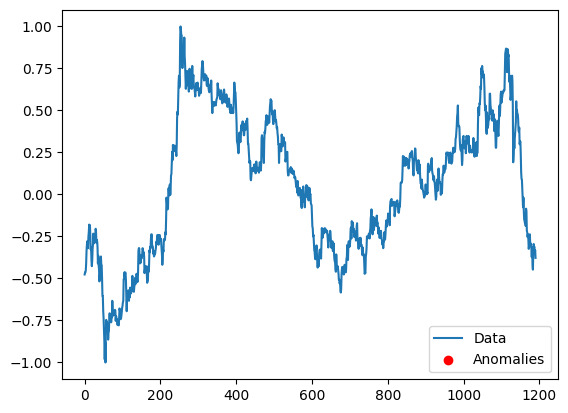

In [ ]:
def detect_anomalies(data, threshold=0.5):
    anomalies = []
    for i, d in enumerate(data):
        d = d.reshape(1, -1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        generated = generator.predict(noise)
        d_score = discriminator.predict(d)
        g_score = discriminator.predict(generated)
        anomaly_score = np.abs(d_score - g_score)

        if anomaly_score > threshold:
            anomalies.append((i, d_score[0][0]))
    return anomalies

# 이상치 탐지 수행
anomalies = detect_anomalies(scaled_data)

# 이상치 시각화
plt.plot(scaled_data, label='Data')
anomaly_points = [anomaly[0] for anomaly in anomalies]
plt.scatter(anomaly_points, scaled_data[anomaly_points], color='red', label='Anomalies')
plt.legend()
plt.show()
